In [1]:
#Citation for the below code
'''
Title: CCMEO LiCNN Training 
Authors: Galen Richardson, Krishan Rajaratnam, Julie Lovitt
Date: 07-14-2021
Version: 1.6
https://www.nrcan.gc.ca/science-and-data/research-centres-and-labs/canada-centre-remote-sensing/21749
'''

'\nTitle: CCMEO LiCNN Training \nAuthors: Galen Richardson, Krishan Rajaratnam, Julie Lovitt\nDate: 02-25-2021\nVersion: 1.5\nhttps://www.nrcan.gc.ca/science-and-data/research-centres-and-labs/canada-centre-remote-sensing/21749\n'

In [1]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,UpSampling2D, Conv2D 
from tensorflow.keras.layers import concatenate,Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#advise us of TF version
print(f"Tensorflow ver. {tf.__version__}")

#for dislaying results
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams['figure.dpi'] = 150 
%matplotlib inline

Tensorflow ver. 2.4.1


# Data Prep

In [3]:
#setting up project dir
project_dir = Path("").resolve()
#1_Lichen_HSV is the name of the current dataset for training/test/val

dataset_name = "Frac_D_LICNN_333"
#Location of the test photo directory and the validation photos
"""MAKE SURE ALL DIRECTORIES (MASK, PHOTOS, VALIDATION) ARE ALL IN THE SAME DIRECTORY"""
train_dir = project_dir / "data/train"
val_dir = project_dir / "data/val"
val_dir = project_dir / "data/test"

# Image size that we are going to use in the Neural Net
IMG_SIZE = 240

train_list = [ str(file) for file in (project_dir / "data/train").iterdir()]
val_list = [ str(file) for file in (project_dir / "data/val").iterdir()]
test_list = [ str(file) for file in (project_dir / "data/test").iterdir()]
train_size, val_size, test_size = len(train_list), len(val_list), len(test_list)
print("The training, validation, and test sets contain {0}, {1}, {2} images respectively".format(train_size,val_size, test_size))

The training, validation, and test sets contain 2000, 200, 200 images respectively


In [4]:
#Used for RTX 3000 cards to manage memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
def parse_image(img_path: str) -> dict:
    #reads data, decodes it, and converts it to a tensor array
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    #normalizes the data to values between 1 and 0
    image = tf.cast(image, tf.float32) / 255.0
    #parsing the mask This stiep uses regex_replace, which replaces the folder name with the mask folder name.
    #used to connect to the mask path
    mask_path = tf.strings.regex_replace(img_path, photo_folder_name, mask_photo_folder_name)
    print(mask_path)
    #reads and decodes the image
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask,tf.float32)
    
    #returns a dictionary whith image, mask pairs
    return {'image': image, 'segmentation_mask': mask}

In [6]:
#Creation of Training dataset
photo_folder_name = "train"
mask_photo_folder_name = 'train_mask'
train_dataset = tf.data.Dataset.from_tensor_slices(train_list)
train_dataset = train_dataset.map(parse_image)

#Creation of Validation dataset
photo_folder_name = "val"
mask_photo_folder_name = 'val_mask'
val_dataset = tf.data.Dataset.from_tensor_slices(val_list)
val_dataset = val_dataset.map(parse_image)

#Creation of test dataset
photo_folder_name = "test"
mask_photo_folder_name = 'test_mask'
test_dataset = tf.data.Dataset.from_tensor_slices(test_list)
test_dataset = test_dataset.map(parse_image)

#creates a dictionary with dataset pairings.
dataset = {"train": train_dataset, "val": val_dataset, "test" : test_dataset}

Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)
Tensor("StaticRegexReplace:0", shape=(), dtype=string)


In [7]:
@tf.function
def apply_symmetry(image, mask, i):
    if i == 0:
        return image, mask
    elif i == 1:
        return tf.image.transpose(image),  tf.image.transpose(mask)
    elif i == 2:
        return tf.image.rot90(image, k=1, name=None), tf.image.rot90(mask, k=1, name=None)
    elif i == 3:
        return tf.image.rot90(image, k=2, name=None), tf.image.rot90(mask, k=2, name=None) 
    elif i ==4:
        return tf.image.rot90(image, k=3, name=None), tf.image.rot90(mask, k=3, name=None)
    elif i == 5:
        return tf.image.flip_left_right(image), tf.image.flip_left_right(mask)
    elif i == 6:
        return tf.image.flip_up_down(image), tf.image.flip_up_down(mask)
    else:
        return image, mask        

In [8]:
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    num = tf.random.uniform(())
    num2 = tf.random.uniform(())
    num3 = tf.random.uniform(())
    num4 = tf.random.uniform(())
    num5 = tf.random.uniform(()) 
    if num >.6 and num <.7:
        input_mask= tf.image.crop_to_bounding_box(input_mask,0, 0, 160, 160)
        input_image= tf.image.crop_to_bounding_box(input_image, 0, 0, 160, 160)
        input_image=tf.image.resize(input_image, (IMG_SIZE,IMG_SIZE),method='nearest')
        input_mask=tf.image.resize(input_mask, (IMG_SIZE,IMG_SIZE),method='nearest')
    if num >.8 and num <.9:
        input_mask= tf.image.crop_to_bounding_box(input_mask,0, 79, 160, 160)
        input_image= tf.image.crop_to_bounding_box(input_image, 0, 79, 160, 160)
        input_image=tf.image.resize(input_image, (IMG_SIZE,IMG_SIZE),method='nearest')
        input_mask=tf.image.resize(input_mask, (IMG_SIZE,IMG_SIZE),method='nearest')   
    if num > .3 and num <.4 :
        input_mask= tf.image.crop_to_bounding_box(input_mask,79, 0, 160, 160)
        input_image= tf.image.crop_to_bounding_box(input_image, 79, 0, 160, 160)
        input_image=tf.image.resize(input_image, (IMG_SIZE,IMG_SIZE),method='nearest')
        input_mask=tf.image.resize(input_mask, (IMG_SIZE,IMG_SIZE),method='nearest')
    if num > .1 and num <.2:
        input_mask= tf.image.crop_to_bounding_box(input_mask,79, 79, 160, 160)
        input_image= tf.image.crop_to_bounding_box(input_image, 79, 79, 160, 160)
        input_image=tf.image.resize(input_image, (IMG_SIZE,IMG_SIZE),method='nearest')
        input_mask=tf.image.resize(input_mask, (IMG_SIZE,IMG_SIZE),method='nearest')
    if num4>.75:
        s_img= tf.image.random_saturation(input_image, 0.5,1)
        c_img= tf.image.random_contrast(s_img, 0.5,.9)
        input_image = tf.clip_by_value(c_img, clip_value_min=0., clip_value_max=1.)
    if num4<.25:
        c_img= tf.image.random_contrast(input_image, 0.5,1)
        input_image = tf.clip_by_value(c_img, clip_value_min=0., clip_value_max=1.)
    if num3<.25:
            b_img=tf.image.adjust_brightness(input_image, -.1)
            input_image = tf.clip_by_value(b_img, clip_value_min=0., clip_value_max=1.)
    input_image, input_mask = apply_symmetry(input_image, input_mask, int(7*num2))
    # One hot encoding for non-standard losses.
    input_mask = tf.one_hot(tf.dtypes.cast(input_mask[...,0], tf.int32) ,3)
    return input_image, input_mask

@tf.function
def load_image_val(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    # One hot encoding for non-standard losses.
    input_mask = tf.one_hot(tf.dtypes.cast(input_mask[...,0], tf.int32) ,3)
    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    #resizes the testing data
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    # One hot encoding for non-standard losses. VERY IMPORTANT
    input_mask = tf.one_hot(tf.dtypes.cast(input_mask[...,0], tf.int32) ,3)
    return input_image, input_mask

In [9]:
BATCH_SIZE = 16
SEED = 42 #so shuffle is the same way, might want to randomize
#Buffer_size affects randomness in model
BUFFER_SIZE = 2000

dataset = {"train": train_dataset, "val": val_dataset, "test" : test_dataset}

#setting and shuffling datasets

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train']

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val']

#-- Test Dataset --#
dataset['test'] = dataset['test'].map(load_image_test)
dataset['test'] = dataset['test'].batch(1)
dataset['test'] = dataset['test']

#confirms the datasets (shape)
print(dataset['train'])
print(dataset['val'])
print(dataset['test'])


<BatchDataset shapes: ((None, 240, 240, 3), (None, 240, 240, 3)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 240, 240, 3), (None, 240, 240, 3)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 240, 240, 3), (None, 240, 240, 3)), types: (tf.float32, tf.float32)>


In [10]:
def display_sample(display_list):
    #function used for showing results
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [11]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    #creation of a predictive mask
    pred_mask = tf.argmax(pred_mask, axis=-1)#which ever class the data is most similar to, it gets assigned that
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    
    return pred_mask
    
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[1], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

## Implement new metrics and losses

In [12]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    """
        y_true and y_pred are m x r x c x n where m is the number of images, r is the number of rows, c is the number of columns, and n is the number of classes.
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [13]:
# From here https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2. 
# Also see: https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow.
def dice_coef(y_true, y_pred, smooth=1e-6):
    """
        y_true and y_pred are m x r x c x n where m is the number of images, r is the number of rows, c is the number of columns, and n is the number of classes.
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [14]:
def IoULoss(y_true, y_pred, smooth=1e-6):
    return 1 - iou_coef(y_true, y_pred)

In [15]:
def DiceLoss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coef(y_true, y_pred)

In [16]:
def ModifiedDiceLoss(y_true, y_pred, smooth=1e-6, modification = 1):
    cce = tf.losses.CategoricalCrossentropy()
    return 1 - dice_coef(y_true, y_pred) + modification * cce(y_true, y_pred) 

In [17]:
def U_model():
    OUTPUT_CHANNELS = 3
    in1 = Input(shape=(None, None, 3 ))
    #changing all dropouts from .2 to .3
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = Dropout(0.3)(conv4)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv4), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)
    
    #defining inputs and outputs of model
    model = Model(inputs=[in1], outputs=[segmentation])
    #loss function needs to be SparseCategoricalCrossentropy
    '''Loss function Issues'''
    losses = {'seg': ModifiedDiceLoss}
    #losses = {'seg': DiceLoss}
    #tf.losses.CategoricalCrossentropy()
    metrics = {'seg': ['acc']}
    #compile the model to create it
    model.compile(optimizer="adam", loss = losses, metrics=['acc', dice_coef, iou_coef])
    
    #look into best loss function for this

    return model
model = U_model()
#model.summary()

In [18]:
def U2_model():
    OUTPUT_CHANNELS = 3
    in1 = Input(shape=(None, None, 3 ))
    #changing all dropouts from .2 to .3
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = Dropout(0.3)(conv4)

    up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)
    
    
    #defining inputs and outputs of model
    model = Model(inputs=[in1], outputs=[segmentation])
    #loss function needs to be SparseCategoricalCrossentropy
    '''Loss function Issues'''
    losses = {'seg': ModifiedDiceLoss}
    #losses = {'seg': DiceLoss}
    #tf.losses.CategoricalCrossentropy()
    metrics = {'seg': ['acc']}
    #compile the model to create it
    model.compile(optimizer="adam", loss = losses, metrics=['acc', dice_coef, iou_coef])
    
    #look into best loss function for this

    return model
#model = U2_model()
#model.summary()

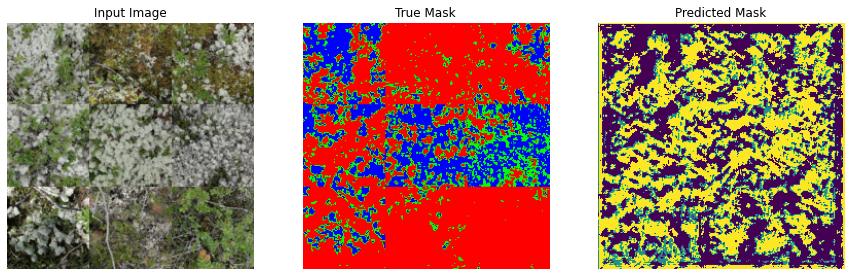

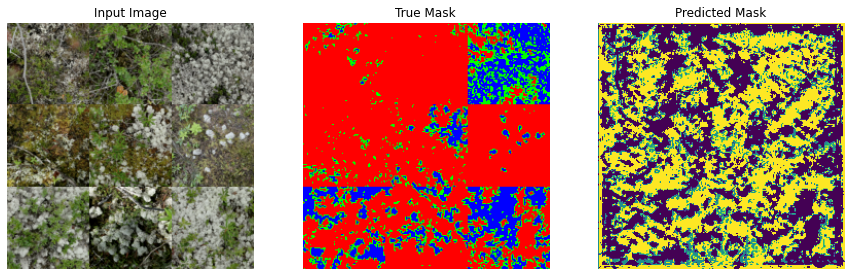

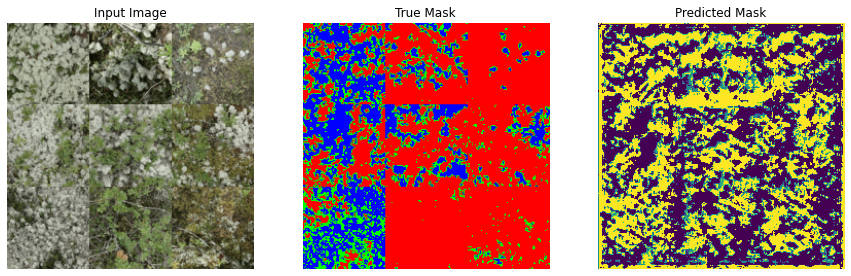

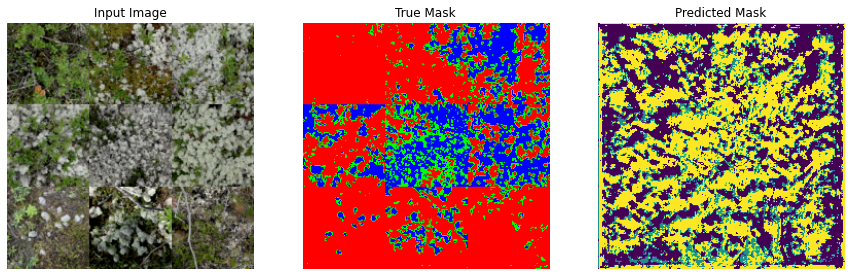

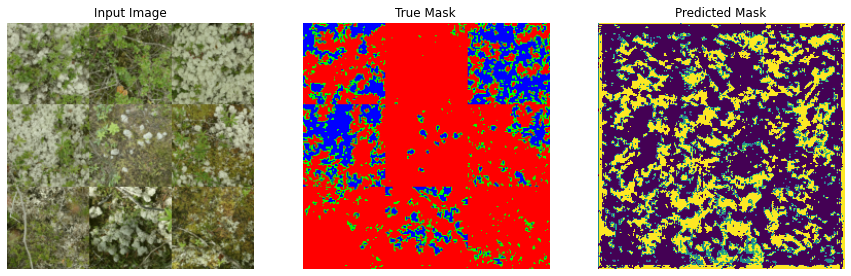

In [18]:
#SANITY CHECK to make sure the model is working
for image, mask in dataset['val'].take(5):
    sample_image, sample_mask = image, mask
    show_predictions()

In [19]:
tf.keras.backend.clear_session()

In [20]:
#Setting up early stopping and model saving

#trained on Frac_D_LiCCN_Lab_1

'''MODEL FILE NAME FOR ACC ASSESSMENT'''
model_file_name = "lichen_DRONE_333_VTAUG.h5"
callbacks = []
callbacks.append(tf.keras.callbacks.ModelCheckpoint(model_file_name, save_best_only=True, 
                                                   save_weights_only=True,))
callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4))

epochs = 30
with tf.device('/gpu:0'):
    model_history = model.fit(dataset['train'], epochs=epochs,
                    steps_per_epoch=500,
                    validation_steps=50,
                    validation_data=dataset['val'],
                    callbacks=callbacks)
model_history

Epoch 1/30
500/500 [==============================] - 110s 184ms/step - loss: 1.1239 - acc: 0.6889 - dice_coef: 0.5898 - iou_coef: 0.4242 - val_loss: 0.5904 - val_acc: 0.8482 - val_dice_coef: 0.7733 - val_iou_coef: 0.6308
Epoch 2/30
500/500 [==============================] - 90s 180ms/step - loss: 0.7610 - acc: 0.7949 - dice_coef: 0.7101 - iou_coef: 0.5523 - val_loss: 0.5359 - val_acc: 0.8636 - val_dice_coef: 0.7941 - val_iou_coef: 0.6588
Epoch 3/30
500/500 [==============================] - 95s 189ms/step - loss: 0.7137 - acc: 0.8078 - dice_coef: 0.7285 - iou_coef: 0.5747 - val_loss: 0.5333 - val_acc: 0.8646 - val_dice_coef: 0.8058 - val_iou_coef: 0.6750
Epoch 4/30
500/500 [==============================] - 93s 186ms/step - loss: 0.6914 - acc: 0.8141 - dice_coef: 0.7371 - iou_coef: 0.5853 - val_loss: 0.5403 - val_acc: 0.8611 - val_dice_coef: 0.8016 - val_iou_coef: 0.6691
Epoch 5/30
500/500 [==============================] - 91s 182ms/step - loss: 0.6831 - acc: 0.8165 - dice_coef: 0.74

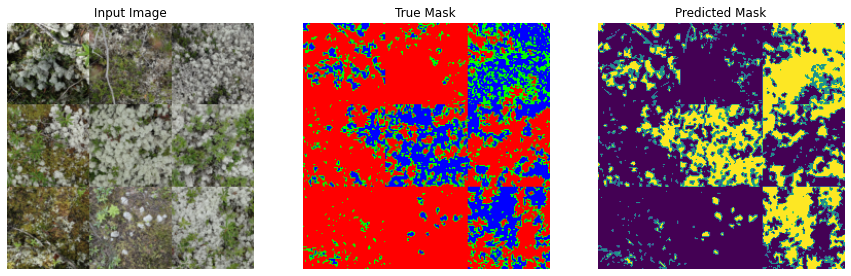

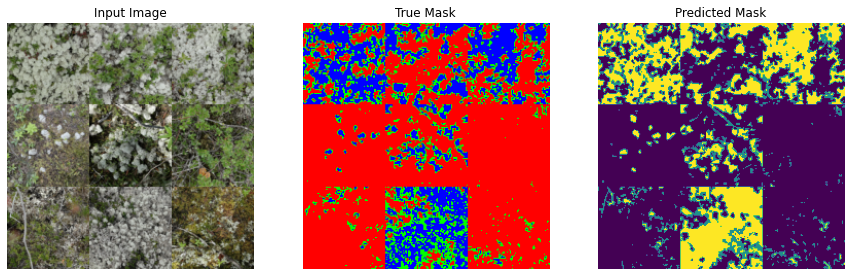

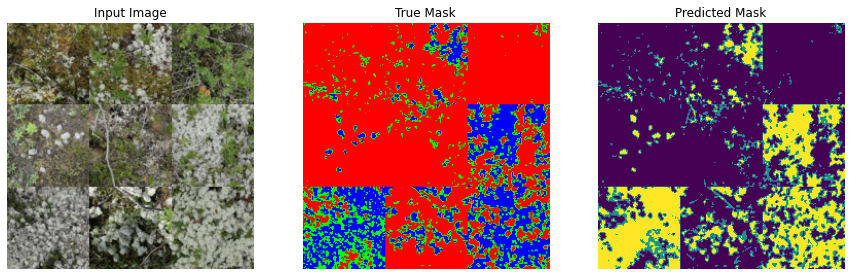

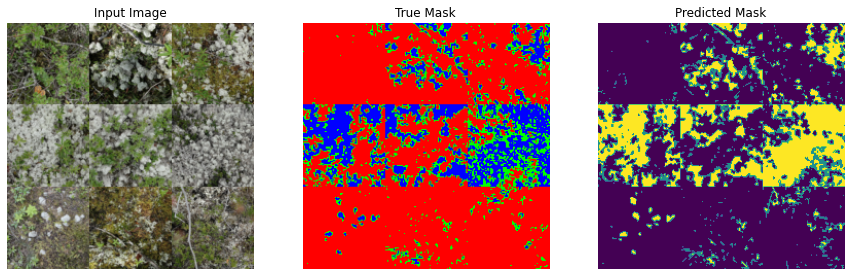

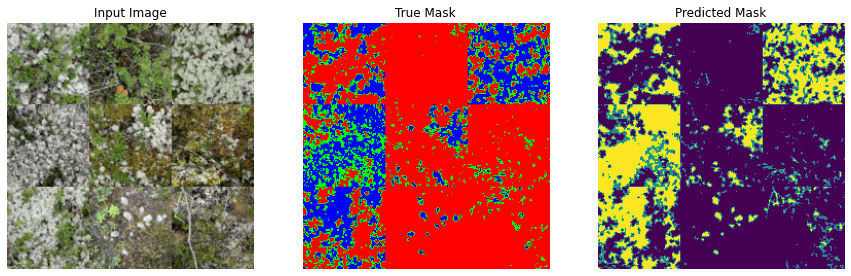

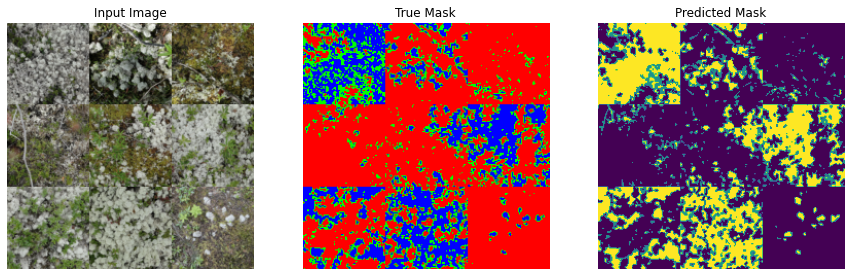

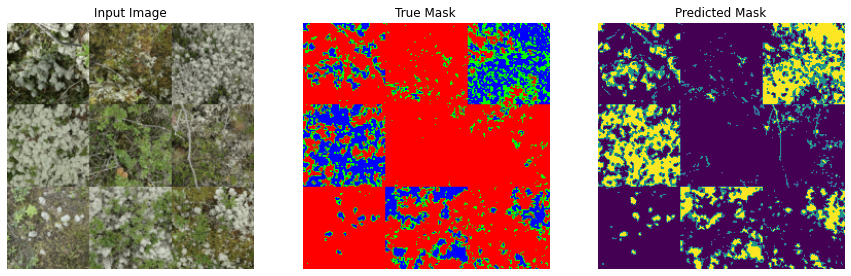

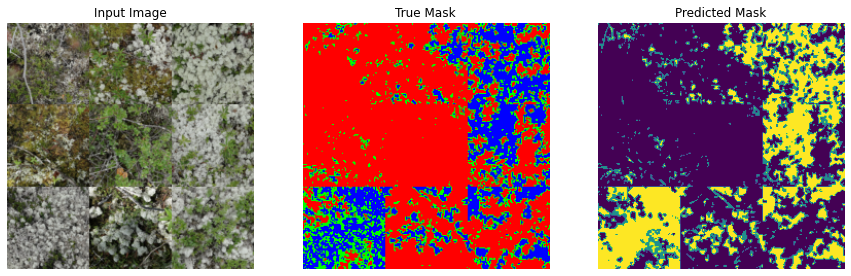

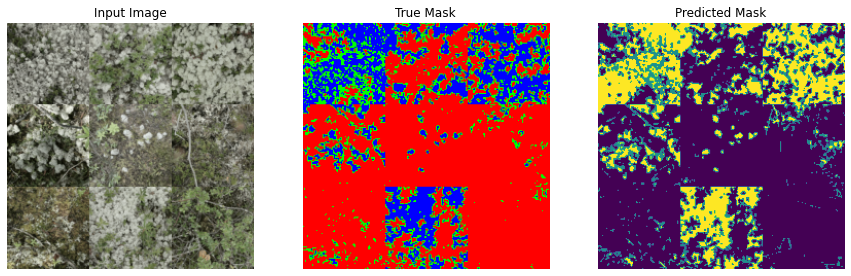

In [21]:
### displaying the results from 3 images
for image, mask in dataset['val'].take(9):
    sample_image, sample_mask = image, mask
    show_predictions()

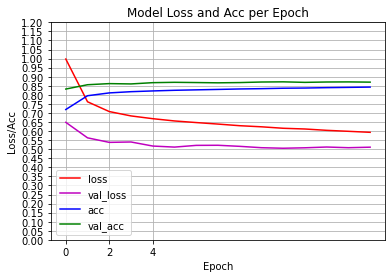

In [23]:
#### epoch = (range(6))
end = 6
#int(str(epoch)[-4:-1])

plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'m')
plt.plot(model_history.history['acc'],'b')
plt.plot(model_history.history['val_acc'],'g')
plt.grid()

#plt.plot(history.history['val_loss'])
plt.title('Model Loss and Acc per Epoch')
plt.ylabel('Loss/Acc')
#plt.axes([0, 0, 10, 0.5])
plt.yticks(np.arange(0, 1.25, 0.05))
plt.xticks(np.arange(0,end,2))

plt.xlabel('Epoch')
plt.legend(['loss','val_loss','acc','val_acc'], loc='lower left')
plt.savefig(str(project_dir / 'TFreading.jpg'),dpi=300)
plt.show()

## Analyze performance on the test set

In [22]:
test_data = list(dataset['test'].as_numpy_iterator())

In [23]:
#rof2.h5
#rof_pure_3.h5
#lichen_all_v2.h5
model_file_name = str(project_dir / "lichen_DRONE_333_VTAUG.h5")
model.load_weights(model_file_name)

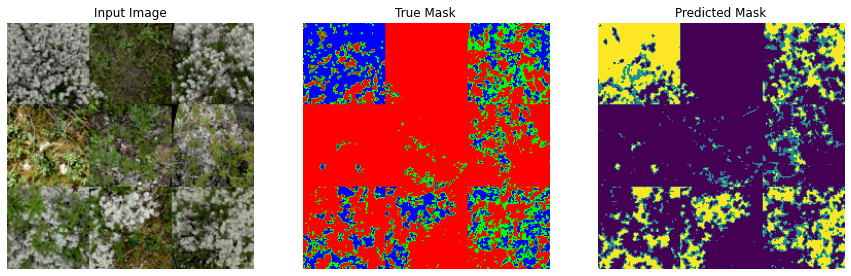

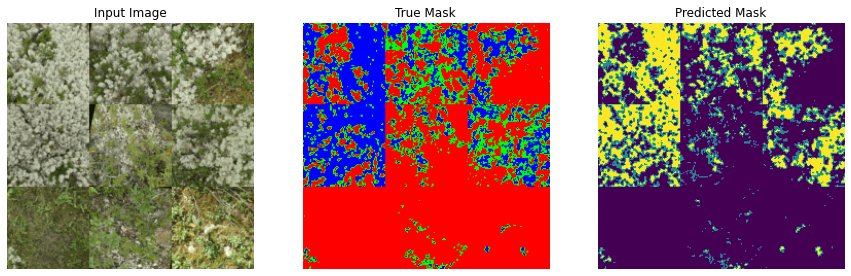

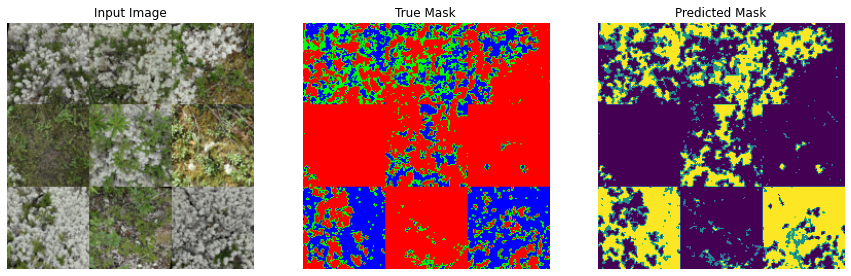

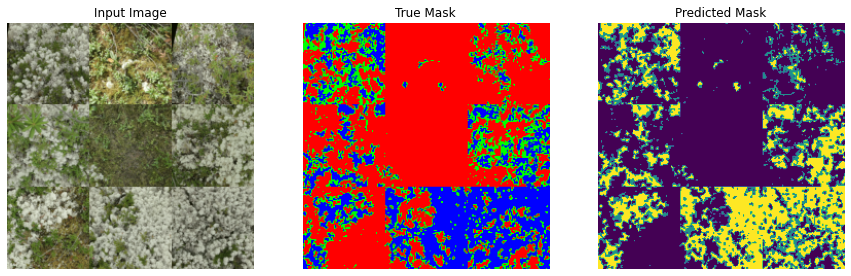

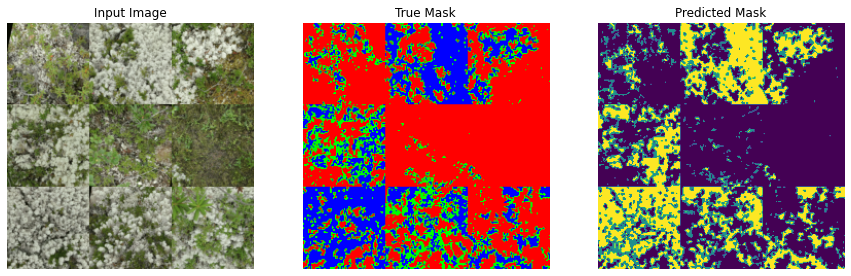

In [24]:
#displaying the results from 3 images
for image, mask in dataset['test'].take(5):
    sample_image, sample_mask = image, mask
    show_predictions()

In [25]:
results = []
indices = []
for i, data in enumerate(test_data):
    sample_image, sample_mask = data
    results.append(model.evaluate(sample_image, sample_mask, verbose=0))
    indices.append(i)
    
df_results = pd.DataFrame(results, columns=["Loss", "Accuracy", "dice_coef", "iou_coef"], index=indices)

In [26]:
df_results.head(6)

Loss  Accuracy  dice_coef  iou_coef
0  0.439359  0.885486   0.837567  0.720529
1  0.629520  0.850278   0.820316  0.695369
2  0.458687  0.882847   0.830703  0.710430
3  0.574501  0.853004   0.815055  0.687843
4  0.564458  0.855434   0.814503  0.687057
5  0.492604  0.870694   0.821729  0.697402

In [27]:
df_results.describe()

Loss    Accuracy   dice_coef    iou_coef
count  200.000000  200.000000  200.000000  200.000000
mean     0.493602    0.874039    0.826899    0.705028
std      0.056962    0.012546    0.010827    0.015724
min      0.411941    0.835625    0.804996    0.673635
25%      0.454185    0.865117    0.818325    0.692512
50%      0.482529    0.876016    0.829356    0.708462
75%      0.525883    0.882934    0.833977    0.715231
max      0.707613    0.893715    0.848264    0.736508

<AxesSubplot:ylabel='Frequency'>

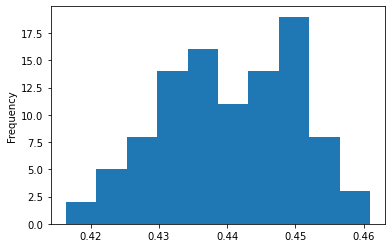

In [25]:
df_results["Loss"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

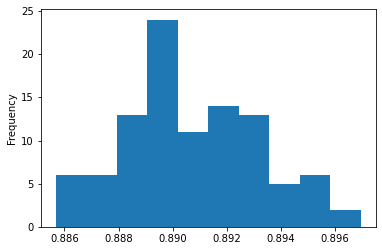

In [26]:
df_results["Accuracy"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

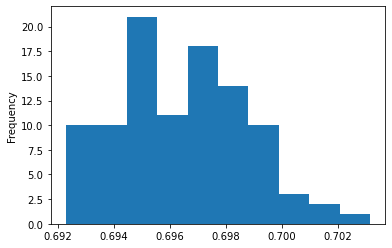

In [28]:
df_results["iou_coef"].plot.hist()

In [29]:
df_results.sort_values(by="dice_coef").head(5)

Loss  Accuracy  dice_coef  iou_coef
16  0.460975  0.885972   0.818172  0.692293
52  0.459232  0.886458   0.818349  0.692547
47  0.455593  0.887500   0.818455  0.692699
50  0.456907  0.888264   0.818554  0.692841
53  0.453990  0.885694   0.818580  0.692878

In [30]:
df_results.sort_values(by="Loss", ascending=False).head(5)

Loss  Accuracy  dice_coef  iou_coef
16  0.460975  0.885972   0.818172  0.692293
52  0.459232  0.886458   0.818349  0.692547
50  0.456907  0.888264   0.818554  0.692841
62  0.456330  0.888403   0.818749  0.693120
47  0.455593  0.887500   0.818455  0.692699

In [31]:
df_results.sort_values(by="Accuracy").head(5)

Loss  Accuracy  dice_coef  iou_coef
53  0.453990  0.885694   0.818580  0.692878
16  0.460975  0.885972   0.818172  0.692293
96  0.454158  0.886111   0.818703  0.693054
52  0.459232  0.886458   0.818349  0.692547
25  0.453022  0.886736   0.818612  0.692924

Review output images with worst loss because this can lead to modifying training/validation datasets or altering the code. It is useful to see what your LiCNN is bad at. 

Predictions for image 16 with loss 0.4609748423099518.


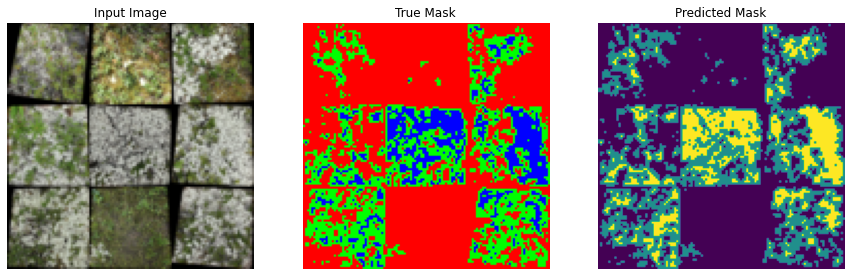

Predictions for image 52 with loss 0.45923158526420593.


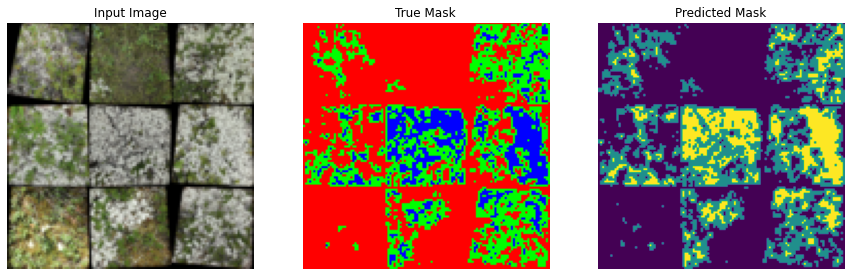

Predictions for image 50 with loss 0.4569069743156433.


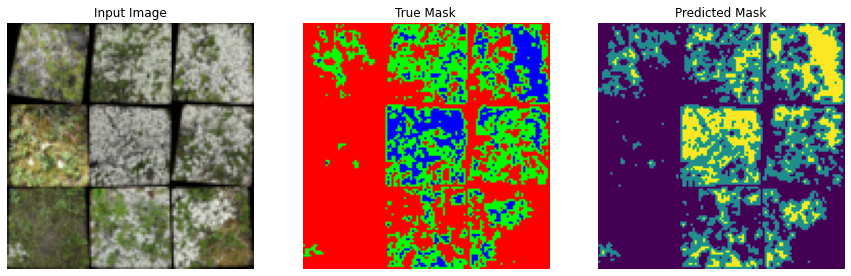

In [32]:
# Input image with worst Loss.
for i in df_results.sort_values(by="Loss", ascending=False)[0:3].index.values:
    print(f"Predictions for image {i} with loss {df_results.loc[i, 'Loss']}.")
    sample_image, sample_mask = test_data[i]
    show_predictions()